In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
commodity_ticker = 'CL=F'  # Ticker for WTI Crude Oil futures
start_date = '2018-01-01'  # Start date of the data
end_date = '2019-12-31'    # End date of the data


# Fetching the data
commodity_data =  yf.download(commodity_ticker, start=start_date, end=end_date )
print(commodity_data.head())


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2018-01-02  60.200001  60.740002  60.099998  60.369999  60.369999  510313
2018-01-03  60.389999  61.970001  60.279999  61.630001  61.630001  673859
2018-01-04  61.959999  62.209999  61.590000  62.009998  62.009998  654363
2018-01-05  61.900002  62.040001  61.090000  61.439999  61.439999  563036
2018-01-08  61.610001  61.970001  61.340000  61.730000  61.730000  616474


In [51]:
commodity_data['20d_MA'] = commodity_data['Close'].rolling(window=20).mean()  # 20-day moving average
commodity_data['50d_MA'] = commodity_data['Close'].rolling(window=50).mean()  # 50-day moving average


In [52]:
def find_support_resistance(data, window=20):
    """
    Identify support and resistance levels.

    :param data: DataFrame with commodity price data.
    :param window: Rolling window size to analyze.
    :return: DataFrame with support and resistance levels.
    """
    data['Support'] = data['Close'].rolling(window=window).min()
    data['Resistance'] = data['Close'].rolling(window=window).max()
    return data

# Applying the function to identify support and resistance levels
commodity_data = find_support_resistance(commodity_data, window=50)  # Using 50 days as an example


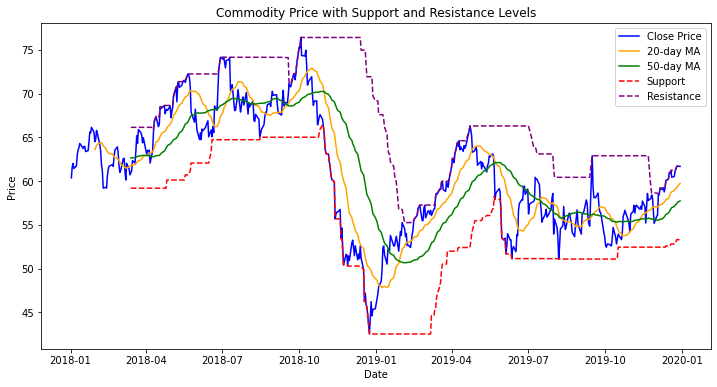

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(commodity_data['Close'], label='Close Price', color='blue')
plt.plot(commodity_data['20d_MA'], label='20-day MA', color='orange')
plt.plot(commodity_data['50d_MA'], label='50-day MA', color='green')
plt.plot(commodity_data['Support'], label='Support', color='red', linestyle='--')
plt.plot(commodity_data['Resistance'], label='Resistance', color='purple', linestyle='--')
plt.title('Commodity Price with Support and Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [54]:
# Parameters for the strategy
proximity_threshold = 0.03  # 3% threshold to define proximity to support or resistance

# Risk management parameters
stop_loss_percent = 0.05  # Stop loss at 5% below buy price (corrected from 0.5 to 0.05)
take_profit_percent = 0.10  # Take profit at 10% above buy price (corrected from 0.2 to 0.10)


# Initialize columns for signals
commodity_data['Buy_Signal'] = False
commodity_data['Sell_Signal'] = False

# Generate signals based on the strategy
for i in range(len(commodity_data)):
    close_price = commodity_data['Close'].iloc[i]
    support_level = commodity_data['Support'].iloc[i]
    resistance_level = commodity_data['Resistance'].iloc[i]

    # Buy signal: If the close price is within the proximity threshold of the support level
    if close_price <= support_level * (1 + proximity_threshold):
        commodity_data.at[commodity_data.index[i], 'Buy_Signal'] = True

    # Sell signal: If the close price is within the proximity threshold of the resistance level
    elif close_price >= resistance_level * (1 - proximity_threshold):
        commodity_data.at[commodity_data.index[i], 'Sell_Signal'] = True

        
commodity_data['Stop_Loss'] = commodity_data['Close'] * (1 - stop_loss_percent)
commodity_data['Take_Profit'] = commodity_data['Close'] * (1 + take_profit_percent)


In [55]:
# Initial setup
initial_capital = 10000.0
capital = initial_capital
position = 0  # No position initially

commodity_data['Position'] = 0.0
commodity_data['Portfolio_Value'] = initial_capital


for i in range(1, len(commodity_data)):
    row = commodity_data.iloc[i]
    
    if row['Buy_Signal'] and position == 0:
        # Buy
        position = capital / row['Close']
        capital = 0
        commodity_data.at[commodity_data.index[i], 'Position'] = position

    elif position > 0 and (row['Sell_Signal'] or 
                           row['Close'] >= row['Take_Profit'] or 
                           row['Close'] <= row['Stop_Loss']):
        # Sell
        capital = position * row['Close']
        position = 0

    commodity_data.at[commodity_data.index[i], 'Portfolio_Value'] = capital + position * row['Close']

    
buy_and_hold_initial_price = commodity_data['Close'].iloc[0]
buy_and_hold_shares = initial_capital / buy_and_hold_initial_price
commodity_data['Buy_and_Hold_Value'] = buy_and_hold_shares * commodity_data['Close']


total_return = commodity_data['Portfolio_Value'].iloc[-1] - initial_capital
return_percentage = (total_return / initial_capital) * 100



In [56]:
# Final calculations for the Range Trading Strategy
range_final_portfolio_value = commodity_data['Portfolio_Value'].iloc[-1]
range_total_return = range_final_portfolio_value - initial_capital
range_return_percentage = (range_total_return / initial_capital) * 100

print("Range Trading Strategy:")
print(f"Final Portfolio Value: {range_final_portfolio_value}")
print(f"Total Return: {range_total_return}")
print(f"Return Percentage: {range_return_percentage}%\n")

# Final calculations for the Buy and Hold Strategy
buy_hold_final_portfolio_value = commodity_data['Buy_and_Hold_Value'].iloc[-1]
buy_hold_total_return = buy_hold_final_portfolio_value - initial_capital
buy_hold_return_percentage = (buy_hold_total_return / initial_capital) * 100

print("Buy and Hold Strategy:")
print(f"Final Portfolio Value: {buy_hold_final_portfolio_value}")
print(f"Total Return: {buy_hold_total_return}")
print(f"Return Percentage: {buy_hold_return_percentage}%")


Range Trading Strategy:
Final Portfolio Value: 12668.0121792415
Total Return: 2668.0121792414993
Return Percentage: 26.680121792414997%

Buy and Hold Strategy:
Final Portfolio Value: 10216.995427607857
Total Return: 216.99542760785698
Return Percentage: 2.1699542760785695%


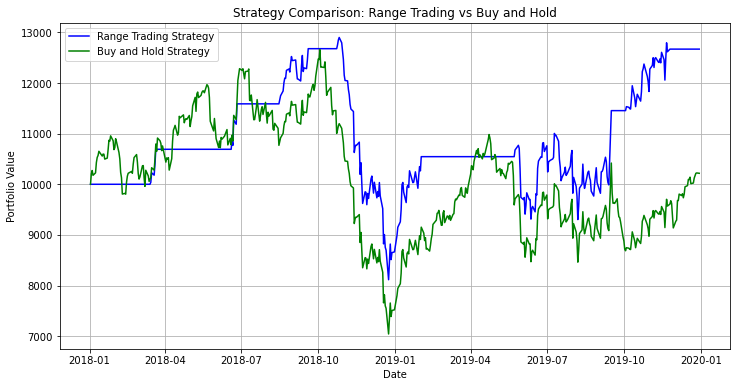

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(commodity_data['Portfolio_Value'], label='Range Trading Strategy', color='blue')
plt.plot(commodity_data['Buy_and_Hold_Value'], label='Buy and Hold Strategy', color='green')
plt.title('Strategy Comparison: Range Trading vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()
